<div class="alert alert-block alert-info">
    <b>[2] is much better and more practical than [1].</b>
</div>

# Implementaion of [1]

- The paper's MSE is diffferent from our result. It is due to dephasing, which is represented by $\alpha$ and $\beta$.
- <mark>This implementation assumes $\alpha=0$ and $\beta=1$.</mark>

- **MSE is the average variance, not standard deviation.**

- The standard deviation informs how faithful is an estimation.

In [1]:
import numpy as np
from numpy import pi, cos, sqrt, log
from matplotlib import pyplot as plt
import statistics as stats
from tqdm import tqdm

In [2]:
f0 = 120e6
w0 = 2 * pi * f0
tau = pi/w0/1.5
alpha = 0
beta = 1

In [3]:
# Trigonometric polynomial of the coin probability

def tripoly1sample(r, m):
    lst = [0] * (2*m + 1)
    lst[0] = r * beta * 1/2
    lst[2*m] = r * beta * 1/2
    lst[m] = 1 + alpha
    
    return np.poly1d(lst)

## Bayesian Estimation (n=1, m=1, 2, ..., N)

In [859]:
N = 50

def toss(m):
    p = .5*(1 + alpha + beta * cos(w0 * m * tau))
    return np.random.choice([1, -1], p=[p, 1-p])

# ml = list(range(1, N+1))
ml = [round((1.1)**i) for i in range(1, N+1)]
# ml = list(range(1, (N+1)//3))*3
rl = [toss(m) for m in ml]

tripolyN = 1
for m, r in zip (ml, rl):
    tripolyN *= tripoly1sample(r, m)
    
coeff = tripolyN.c
M = (len(coeff)-1)//2
coeff = np.divide(coeff, coeff[M])

coeff_avg = []
for n in range(-M, M+1):
    if n == 0:
        coeff_avg.append(pi/2)
    else:
        coeff_avg.append(((-1)**n-1)/n**2/pi)

coeff_sqavg = []
for n in range(-M, M+1):
    if n == 0:
        coeff_sqavg.append(pi**2/3)
    else:
        coeff_sqavg.append((-1)**n*2/n**2)

avg = np.dot(coeff, coeff_avg)/2/pi/tau
sqavg = np.dot(coeff, coeff_sqavg)/(2*pi*tau)**2
sd = sqrt(sqavg-avg**2)

print(f"Avg: {avg/1e6:.6f}")
print(f"Std: {sd/1e6:.6f}")

Avg: 104.725856
Std: 0.214899


## Adaptive Method

# Implementation on [2]

- Coin probability: $P(r\vert\omega,t)=\frac{1}{2}(1+\cos\omega t)$
- We assume prior $P(\omega)\sim\mathcal{N}(\mu,\sigma^2)$ and update it using mean and variation given by posteiror.
- We don't restrict a range for $\omega$ but arbitrary set an initial prior.
- <mark>This implementation assumes $\alpha=0$ and $\beta=1$.</mark>

In [294]:
import numpy as np
from numpy import pi, cos, sin, sqrt, log, exp
from matplotlib import pyplot as plt
import statistics as stats
from tqdm import tqdm

Avg: 104.676118
Std: 1.002488


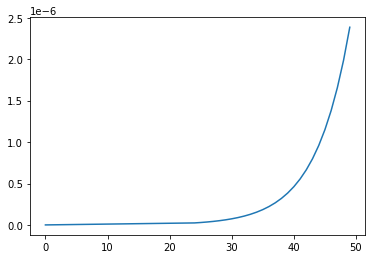

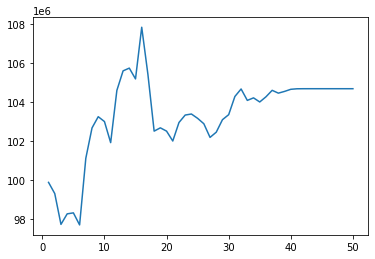

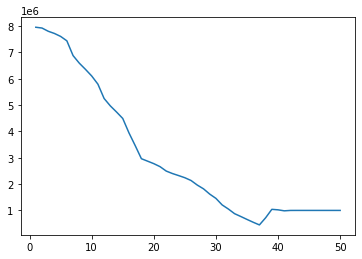

In [892]:
N = 50

f0 = 105e6
w0 = 2 * pi * f0
alpha = 0
beta = 1

def toss(t):
    p = .5*(1 + alpha + beta * cos(w0 * t))
    return np.random.choice([1, -1], p=[p, 1-p])

init_f = 100e6
mu = 2 * pi * init_f
init_sd = 50e6
var = init_sd**2

# tl = np.linspace(1e-9, N*1e-9, N)
# tl = [1.12**i*1/4/init_f for i in range(1, N+1)]


# Hybrid approach (Linear + exponential distribution of t's)

# This is an ad-hoc solution optimized for N=50
N = 50
tl = list(np.linspace(1e-9, N/2*1e-9, N//2))
tl +=  [10*1.2**i*1/4/init_f for i in range(1, N//2+1)]

# This is not optimized.
# N = 30
# tl = list(np.linspace(1e-9, N/2*1e-9, 25))
# tl +=  [6*1.25**i*1/4/init_f for i in range(1, 6)]


rl = [toss(t) for t in tl]
fl = []
fsdl = []

for t, r in zip(tl, rl):
    #print(f"{r}, {mu/1e6:.2f}, {sqrt(var)/1e6:.2f}")
    
    e = exp(-.5*var*t**2)

    new_mu = mu - (r * var * t * sin(mu*t) * e)/(1 + r * cos(mu*t) * e)
    new_var = var - r * var**2 * t**2 * e * (cos(mu*t) + r * e)/(1 + r * cos(mu*t) * e)**2
    
    mu = new_mu
    var = new_var
    
    fl.append(mu/2/pi)
    fsdl.append(sqrt(var)/2/pi)
    
print(f"Avg: {mu/2/pi/1e6:.6f}")
print(f"Std: {sqrt(var)/2/pi/1e6:.6f}")

plt.plot(range(len(tl)), tl)
plt.show()
plt.plot(range(1, N+1), fl)
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()
plt.plot(range(1, N+1), fsdl)
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()

## Adaptive Method

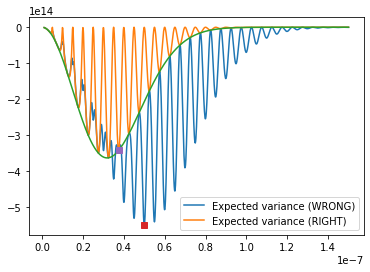

In [965]:
N = 1000

alpha = 0
beta = 1

init_f = 100e6
mu = 2 * pi * init_f
init_sdf = 5e6
var = (init_sdf*2*pi)**2

def coin_prob(t, r):
    return .5*(1 + r * (alpha + beta * cos(mu * t)))

def new_var(t, r):
    e = exp(-.5*var*t**2)
    return - r * var**2 * t**2 * e * (cos(mu*t) + r*e)/(1 + r * cos(mu*t) * e)**2

def new_var2(t):
    e = exp(-.5*var*t**2)
    return -var**2*t**2*sin(mu*t)**2/(e**(-2)-cos(mu*t)**2)

def envelope(t):
    return -var**2*t**2*exp(-t**2*var)

tl = np.linspace(1e-9, 150e-9, N)
varl = [sum([coin_prob(t, r) * new_var(t, r) for r in [-1, 1]]) for t in tl]
var2l = [new_var2(t) for t in tl]
envl = [envelope(t) for t in tl]

plt.plot(tl, varl, label='Expected variance (WRONG)')
plt.plot(tl, var2l, label='Expected variance (RIGHT)')

plt.plot(tl, envl)
x = pi/mu*round(mu/pi*1.599/sqrt(var))
y = sum([coin_prob(x, r) * new_var(x, r) for r in [-1, 1]])
plt.plot(x, y, 's')
k = round(mu/pi/sqrt(var)+.5)
t = (k+.5)*pi/mu
y = new_var2(t)
plt.plot(t, y, 's')
plt.legend()
plt.show()

<div class="alert alert-block alert-success">
<b>IT WORKS!!</b> 
</div>

Avg: 105.00001098798782
Std: 5.4681132154704925e-05


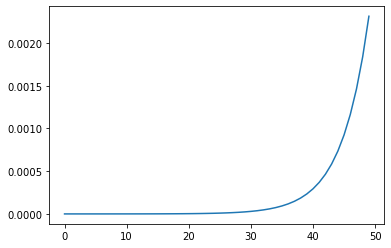

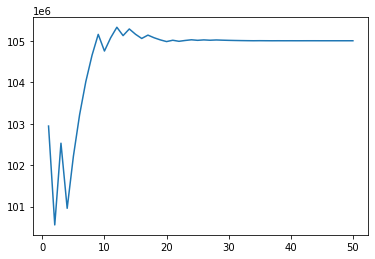

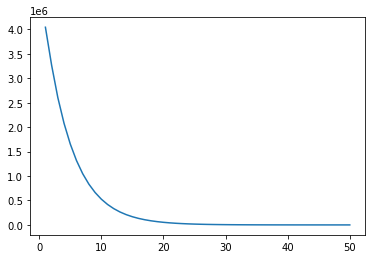

In [966]:
N = 50

f0 = 105e6
w0 = 2 * pi * f0
alpha = 0
beta = 1

def toss(t):
    p = .5*(1 + alpha + beta * cos(w0 * t))
    return np.random.choice([1, -1], p=[p, 1-p])

init_f = 100e6
mu = 2 * pi * init_f
init_sdf = 5e6
var = (init_sdf*2*pi)**2

tl = []
rl = []
fl = []
fsdl = []

for _ in range(N):
    k = round(mu/pi/sqrt(var)+.5)
    t = (k+.5)*pi/mu
    r = toss(t)
    tl.append(t)
    rl.append(r)
    
    e = exp(-.5*var*t**2)
    
    new_mu = mu - (r * var * t * sin(mu*t) * e)/(1 + r * cos(mu*t) * e)
    new_var = var - r * var**2 * t**2 * e * (cos(mu*t) + r * e)/(1 + r * cos(mu*t) * e)**2
    
    mu = new_mu
    var = new_var
    
    fl.append(mu/2/pi)
    fsdl.append(sqrt(var)/2/pi)
    
print(f"Avg: {mu/2/pi/1e6}")
print(f"Std: {sqrt(var)/2/pi/1e6}")

plt.plot(range(len(tl)), tl)
plt.show()
plt.plot(range(1, N+1), fl)
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()
plt.plot(range(1, N+1), fsdl)
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()

# Implementation of [2] considering dephasing

- Coin probability: $P(r\vert\omega,t)=\frac{1}{2}(1+\cos\omega t)$
- We assume prior $P(\omega)\sim\mathcal{N}(\mu,\sigma^2)$ and update it using mean and variation given by posteiror.
- We don't restrict a range for $\omega$ but arbitrary set an initial prior.
- <mark>This implementation does not assume $\alpha=0$ and $\beta=1$.</mark>

## Adaptive method


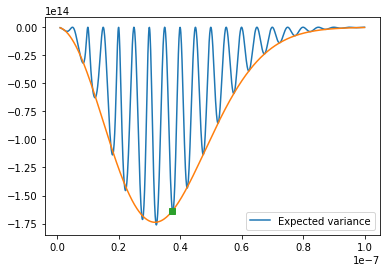

In [967]:
N = 1000

alpha = 0.25
beta = 0.67

init_f = 100e6
mu = 2 * pi * init_f
init_sdf = 5e6
var = (init_sdf*2*pi)**2

def new_var(t):
    e = exp(-.5*var*t**2)
    return -(beta*t*var*e)**2*sin(mu*t)**2/(1-(alpha+beta*cos(mu*t)*e)**2)

def envelope(t):
    return -var**2*t**2*exp(-t**2*var)/(1-alpha**2)*beta**2

tl = np.linspace(1e-9, 100*1e-9, N)
varl = [new_var(t) for t in tl]
envl = [envelope(t) for t in tl]

plt.plot(tl, varl, label='Expected variance')
plt.plot(tl, envl)

k = round(mu/pi/sqrt(var)+.5)
t = (k+.5)*pi/mu
y = new_var(t)
plt.plot(t, y, 's')

plt.legend()
plt.show()

Avg: 105.15767410987893
Std: 0.23475814924290334


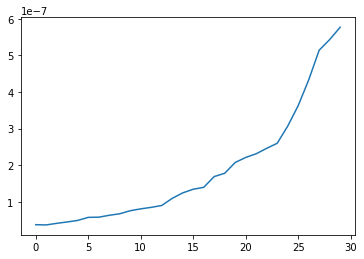

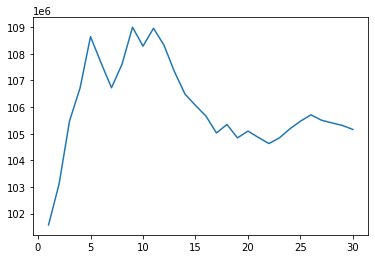

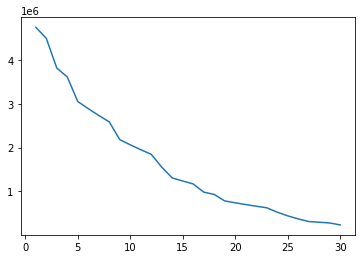

In [1037]:
N = 30

f0 = 105e6
w0 = 2 * pi * f0
alpha = 0.25
beta = 0.67

def toss(t):
    p = .5*(1 + alpha + beta * cos(w0 * t))
    return np.random.choice([1, -1], p=[p, 1-p])

init_f = 100e6
mu = 2 * pi * init_f
init_sdf = 5e6
var = (init_sdf*2*pi)**2

tl = []
rl = []
fl = []
fsdl = []

for _ in range(N):
    k = round(mu/pi/sqrt(var)+.5)
    t = (k+.5)*pi/mu
    r = toss(t)
    tl.append(t)
    rl.append(r)
    
    e = exp(-.5*var*t**2)
    
    new_mu = mu - (r * beta * var * t * sin(mu*t) * e)/(1 + r * alpha + r * beta * cos(mu*t) * e)
    new_var = var - r * beta * var**2 * t**2 * e * ((1+r*alpha)*cos(mu*t) + r*beta*e)/(1+r*alpha + r*beta*cos(mu*t)*e)**2
    
    mu = new_mu
    var = new_var
    
    fl.append(mu/2/pi)
    fsdl.append(sqrt(var)/2/pi)
    
print(f"Avg: {mu/2/pi/1e6}")
print(f"Std: {sqrt(var)/2/pi/1e6}")

plt.plot(range(len(tl)), tl)
plt.show()
plt.plot(range(1, N+1), fl)
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()
plt.plot(range(1, N+1), fsdl)
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()

# Reference

[1] Sergeevich, A., Chandran, A., Combes, J., Bartlett, S. D., & Wiseman, H. M. (2011). Characterization of a qubit Hamiltonian using adaptive measurements in a fixed basis. Physical Review A - Atomic, Molecular, and Optical Physics, 84(5), 052315. https://doi.org/10.1103/PhysRevA.84.052315

[2] Ferrie, C., Granade, C. E., & Cory, D. G. (2013). How to best sample a periodic probability distribution, or on the accuracy of Hamiltonian finding strategies. Quantum Information Processing 2012 12:1, 12(1), 611–623. https://doi.org/10.1007/S11128-012-0407-6